# Section4 Project / AI10_이수철

# CNN을 활용한 검색 엔진 모델 

In [ ]:
!pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ddppsc","key":"f354bc4ab1a0c23b9a3ba2efa63a4bff"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:07<00:00, 39.8MB/s]
100% 346M/346M [00:08<00:00, 45.3MB/s]


In [ ]:
!ls

intel-image-classification.zip	kaggle.json  sample_data


In [ ]:
!unzip intel-image-classification.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating

## 데이터 설명

##Context##
This is image data of Natural Scenes around the world.

##Content##
This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

##Acknowledgements##
Thanks to https://datahack.analyticsvidhya.com for the challenge and Intel for the Data

Photo by Jan Böttinger on Unsplash

##Inspiration##
Want to build powerful Neural network that can classify these images with more accuracy.

In [ ]:
# 필요한 모듈
import glob
import os

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

데이터 라벨링

In [ ]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for labels in os.listdir(directory): 
        if labels == 'buildings': 
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'glacier':
            label = 2
        elif labels == 'mountain':
            label = 3
        elif labels == 'sea':
            label = 4
        elif labels == 'street':
            label = 5
            
        for image_file in os.listdir(os.path.join(directory, labels)): 
            image = cv2.imread(os.path.join(directory, labels)+'/'+image_file)
            image = cv2.resize(image,(150,150)) 
            Images.append(image)
            Labels.append(label)
    
    return Images, Labels

In [ ]:
def get_classlabel(class_code):
    labels = {0:'buildings', 1:'forest', 2:'glacier', 3:'mountain', 4:'sea', 5:'street'}
    
    return labels[class_code]

train data와 test data를 np행렬로 변환

In [ ]:
Images, Labels = get_images('../content/seg_train/seg_train') 

Images_train = np.array(Images)
Labels_train = np.array(Labels)

In [ ]:
Images_train.shape, Labels_train.shape

((14034, 150, 150, 3), (14034,))

In [ ]:
Images_test, Labels_test = get_images('../content/seg_test/seg_test') 

Images_test = np.array(Images_test) 
Labels_test = np.array(Labels_test)

In [ ]:
Images_test.shape, Labels_test.shape

((3000, 150, 150, 3), (3000,))

In [ ]:
# 필요한 라이브러리 import
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### ImageDataGenerator는 학습데이터 양이 적을 경우 주로 사용하나, 사용하는 데이터가 풍경 사진임을 감안해 학습데이터를 조금씩 변형시켜 늘리는 방향으로 진행해보았다.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range=40,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest') 

val_datagen = ImageDataGenerator(rescale = 1.0/255)

In [ ]:
train_datagen.fit(Images_train)
val_datagen.fit(Images_test)

CNN 모델 구현

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),strides=1,padding='same',activation='relu',input_shape=(Images_train.shape[1],Images_train.shape[2],3)))
model.add(BatchNormalization())
model.add(MaxPool2D(3,3))
model.add(Conv2D(64,(3,3), strides=1,padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(3,3))
model.add(Conv2D(128,(3,3), strides=1,padding= 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(3,3))

model.add(GlobalAveragePooling2D())
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(6, activation = "softmax"))

model.compile(optimizer = 'adam' , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit_generator(train_datagen.flow(Images_train, Labels_train, batch_size=32),
                              validation_data=val_datagen.flow(Images_test, Labels_test, batch_size=128), 
                              epochs=5, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/5
439/439 [==============================] - 112s 232ms/step - loss: 1.0366 - accuracy: 0.5916 - val_loss: 1.5234 - val_accuracy: 0.4093
Epoch 2/5
439/439 [==============================] - 98s 223ms/step - loss: 0.8236 - accuracy: 0.6856 - val_loss: 1.3732 - val_accuracy: 0.5407
Epoch 3/5
439/439 [==============================] - 97s 221ms/step - loss: 0.7227 - accuracy: 0.7383 - val_loss: 0.8755 - val_accuracy: 0.6460
Epoch 4/5
439/439 [==============================] - 98s 224ms/step - loss: 0.6683 - accuracy: 0.7542 - val_loss: 1.0014 - val_accuracy: 0.5980
Epoch 5/5
439/439 [==============================] - 110s 250ms/step - loss: 0.6179 - accuracy: 0.7713 - val_loss: 0.9540 - val_accuracy: 0.6947


train data와 test data의 학습에 따른 accuracy 시각화

In [ ]:
def metrics_plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

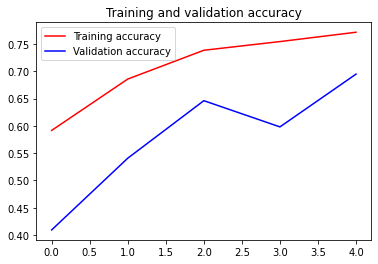

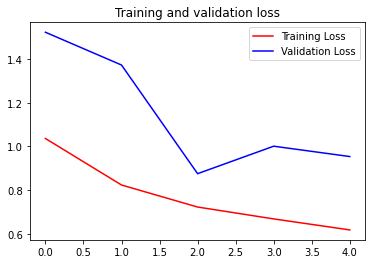

In [ ]:
metrics_plot(history)

학습된 CNN 모델을 통해 예측할 데이터 불러오기

In [ ]:
pred_Images,no_Labels = get_images('../content/seg_pred')
pred_Images = np.array(pred_Images)
pred_Images.shape

(7301, 150, 150, 3)

In [ ]:
prediction = model.predict(pred_Images[:10]/255.0)

In [ ]:
class_prediction = [np.argmax(i) for i in prediction]
print(class_prediction)

[5, 4, 1, 4, 3, 5, 4, 1, 2, 5]


예측 결과 시각화

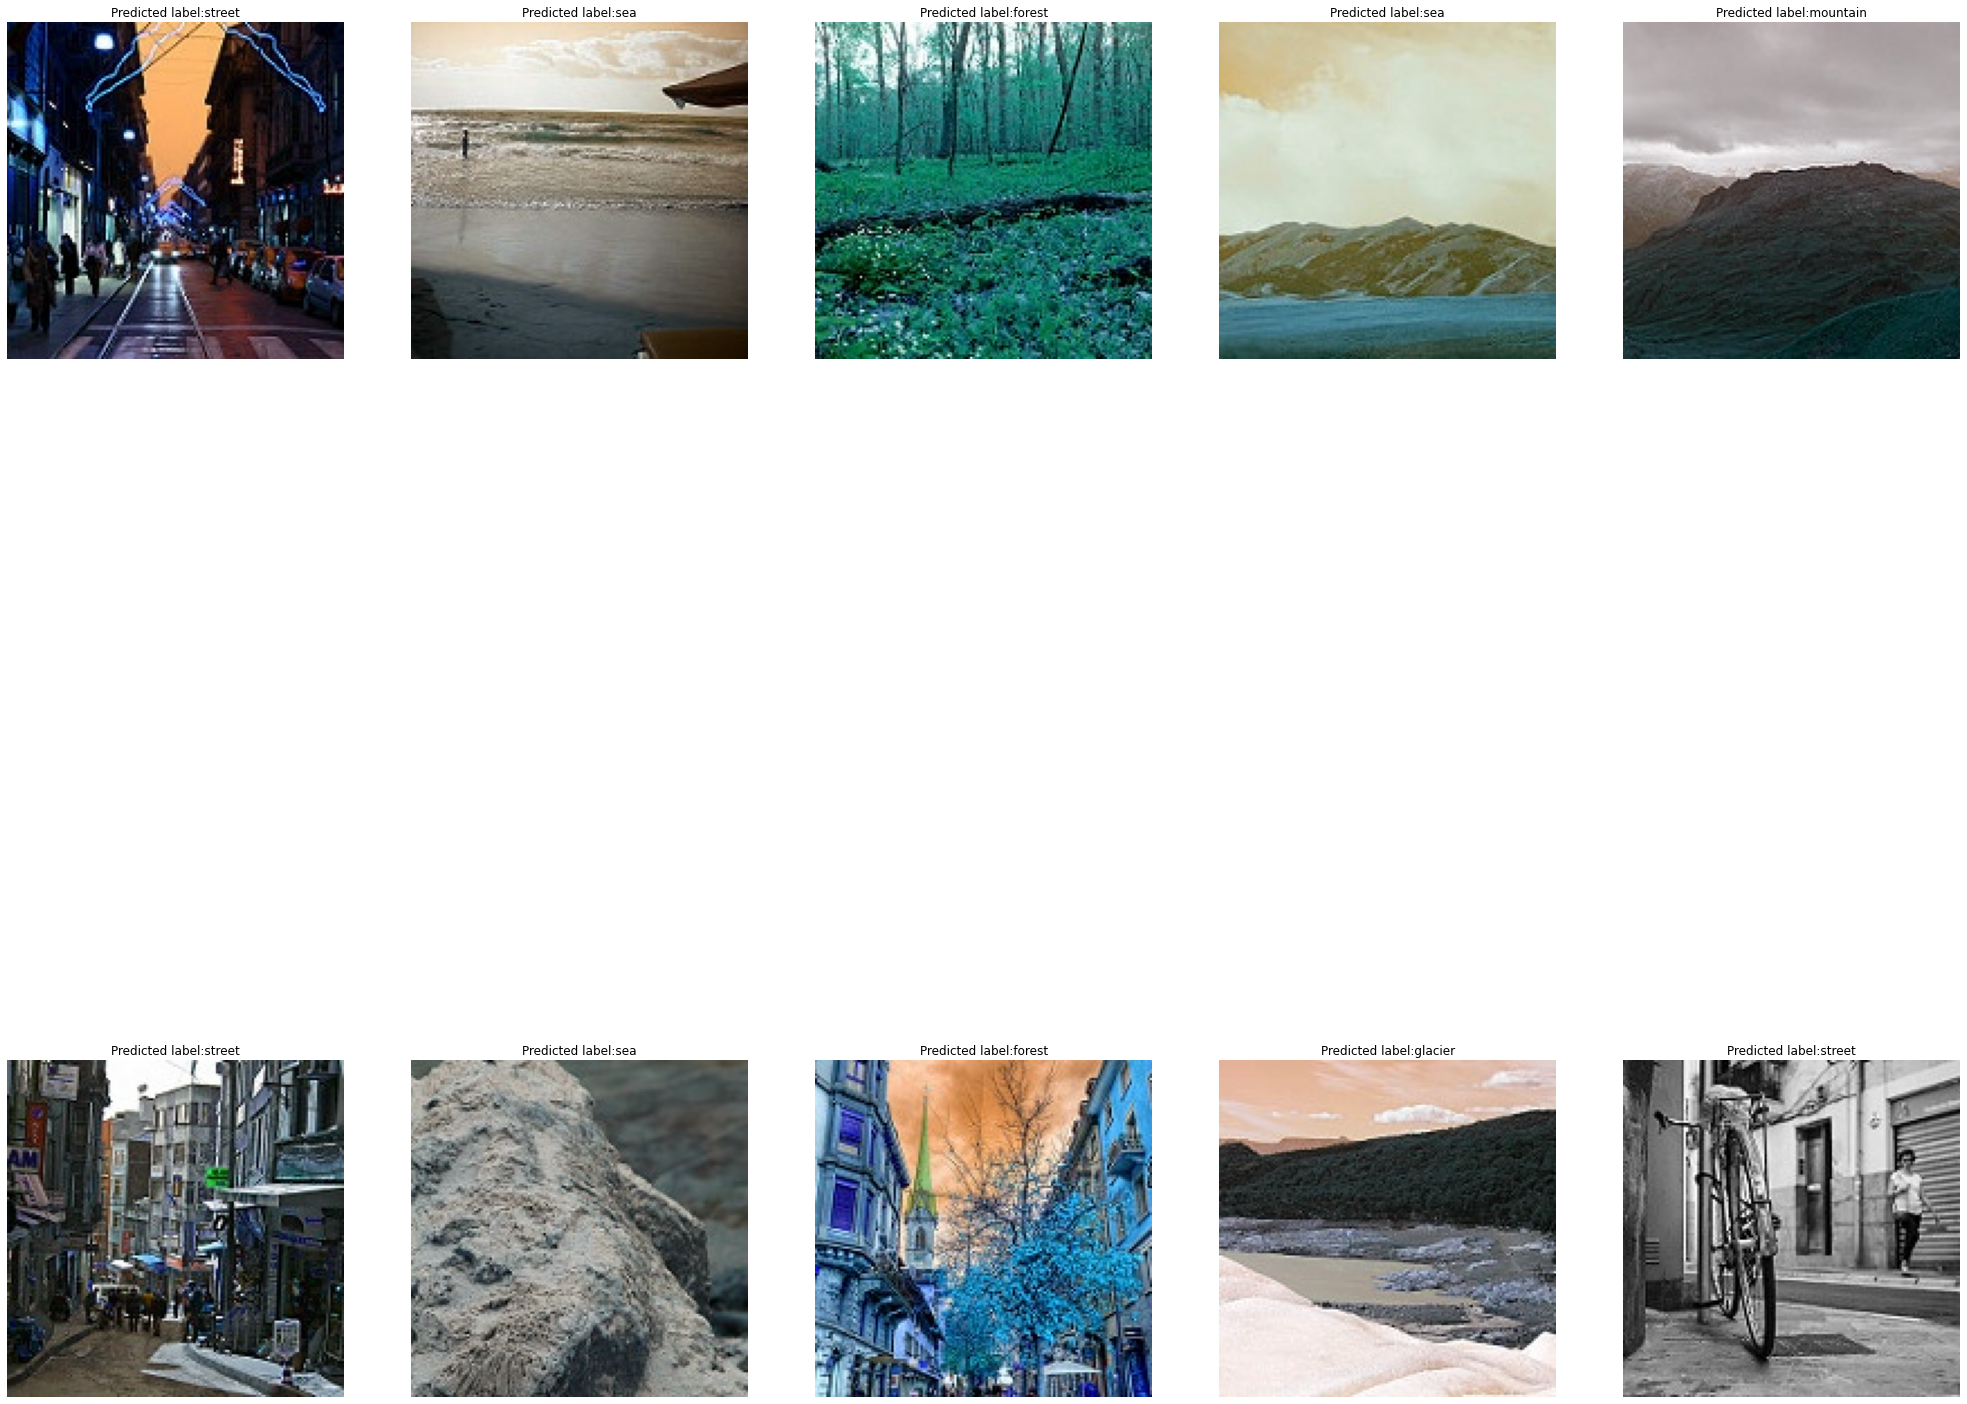

In [ ]:
plt.figure(figsize=(35,35))
c = 1
for i in range(10):
    plt.subplot(2,5,c)
    plt.imshow(pred_Images[i])
    plt.title('Predicted label:{}'.format(get_classlabel(class_prediction[i])))
    plt.axis('off')
    c = c+1